In [261]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [262]:
import zipfile

zip_path = '/content/drive/MyDrive/Colab Notebooks/pnemonia.zip'
extract_path = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
     zip_ref.extractall(extract_path)



In [263]:
# Importing all important libraries needed for image processing, deep learning model, data handling and visualization

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cv2, os, random
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode, plot, iplot

import glob
import tensorflow
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm
from termcolor import colored
import albumentations as A

from warnings import filterwarnings
filterwarnings("ignore")

from sklearn import set_config
set_config(print_changed_only=False)

# Setting the main dataset path
data_path = "/content/chest_xray/chest_xray"


In [264]:
# Loading all image file paths for training, testing and validation from folders

train_images = glob.glob("/content/chest_xray/train/**/*.jpeg")
test_images = glob.glob("/content/chest_xray/test/**/*.jpeg")
val_images = glob.glob("/content/chest_xray/val/**/*.jpeg")


In [265]:
# Checking first 5 image paths from train and test folders

train_images[:5], test_images[:5]


(['/content/chest_xray/train/PNEUMONIA/person500_bacteria_2106.jpeg',
  '/content/chest_xray/train/PNEUMONIA/person558_virus_1098.jpeg',
  '/content/chest_xray/train/PNEUMONIA/person465_bacteria_1977.jpeg',
  '/content/chest_xray/train/PNEUMONIA/person326_bacteria_1506.jpeg',
  '/content/chest_xray/train/PNEUMONIA/person1646_bacteria_4368.jpeg'],
 ['/content/chest_xray/test/PNEUMONIA/person3_virus_16.jpeg',
  '/content/chest_xray/test/PNEUMONIA/person1647_virus_2848.jpeg',
  '/content/chest_xray/test/PNEUMONIA/person100_bacteria_479.jpeg',
  '/content/chest_xray/test/PNEUMONIA/person77_virus_139.jpeg',
  '/content/chest_xray/test/PNEUMONIA/person1_virus_9.jpeg'])

In [266]:
# Printing how many images are there in train, test and validation datasets

print("There are {} images in the training dataset".format(len(train_images)))
print("There are {} images in the test dataset".format(len(test_images)))
print("There are {} images in the validation dataset".format(len(val_images)))


There are 5216 images in the training dataset
There are 624 images in the test dataset
There are 16 images in the validation dataset


In [267]:
# Collecting all pneumonia and normal lung image paths from train, test and validation folders

dataset_types = ["train", "test", "val"]
pneumonia_images = []
normal_images = []

for dataset in dataset_types:
    folder_path = os.path.join(data_path, dataset)
    normal = glob.glob(os.path.join(folder_path, "NORMAL/*.jpeg"))
    pneumonia = glob.glob(os.path.join(folder_path, "PNEUMONIA/*.jpeg"))
    normal_images.extend(normal)
    pneumonia_images.extend(pneumonia)

print("The number of pneumonia images is {}".format(len(pneumonia_images)))
print("The number of normal lung images is {}".format(len(normal_images)))


The number of pneumonia images is 4273
The number of normal lung images is 1583


NORMAL


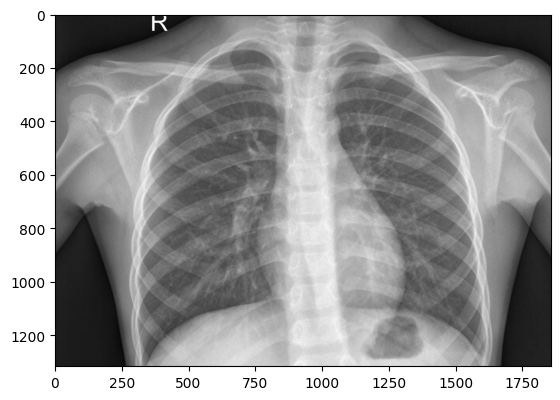

In [268]:
# Loading and showing one sample image from the normal lung category

normal_sample = load_img("/content/chest_xray/chest_xray/test/NORMAL/IM-0001-0001.jpeg")
print("NORMAL")
plt.imshow(normal_sample)
plt.show()


PNEUMONIA


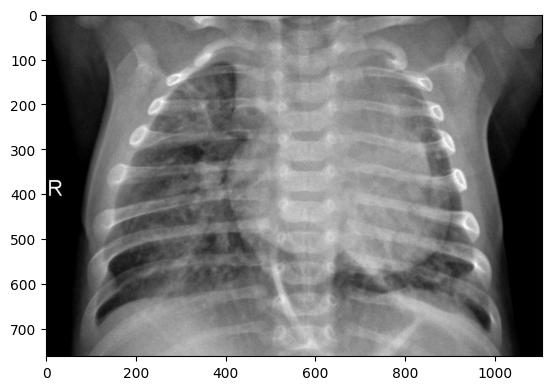

In [269]:
# Loading and showing one sample image from the pneumonia category

pneumonia_sample = load_img("/content/chest_xray/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg")
print("PNEUMONIA")
plt.imshow(pneumonia_sample)
plt.show()


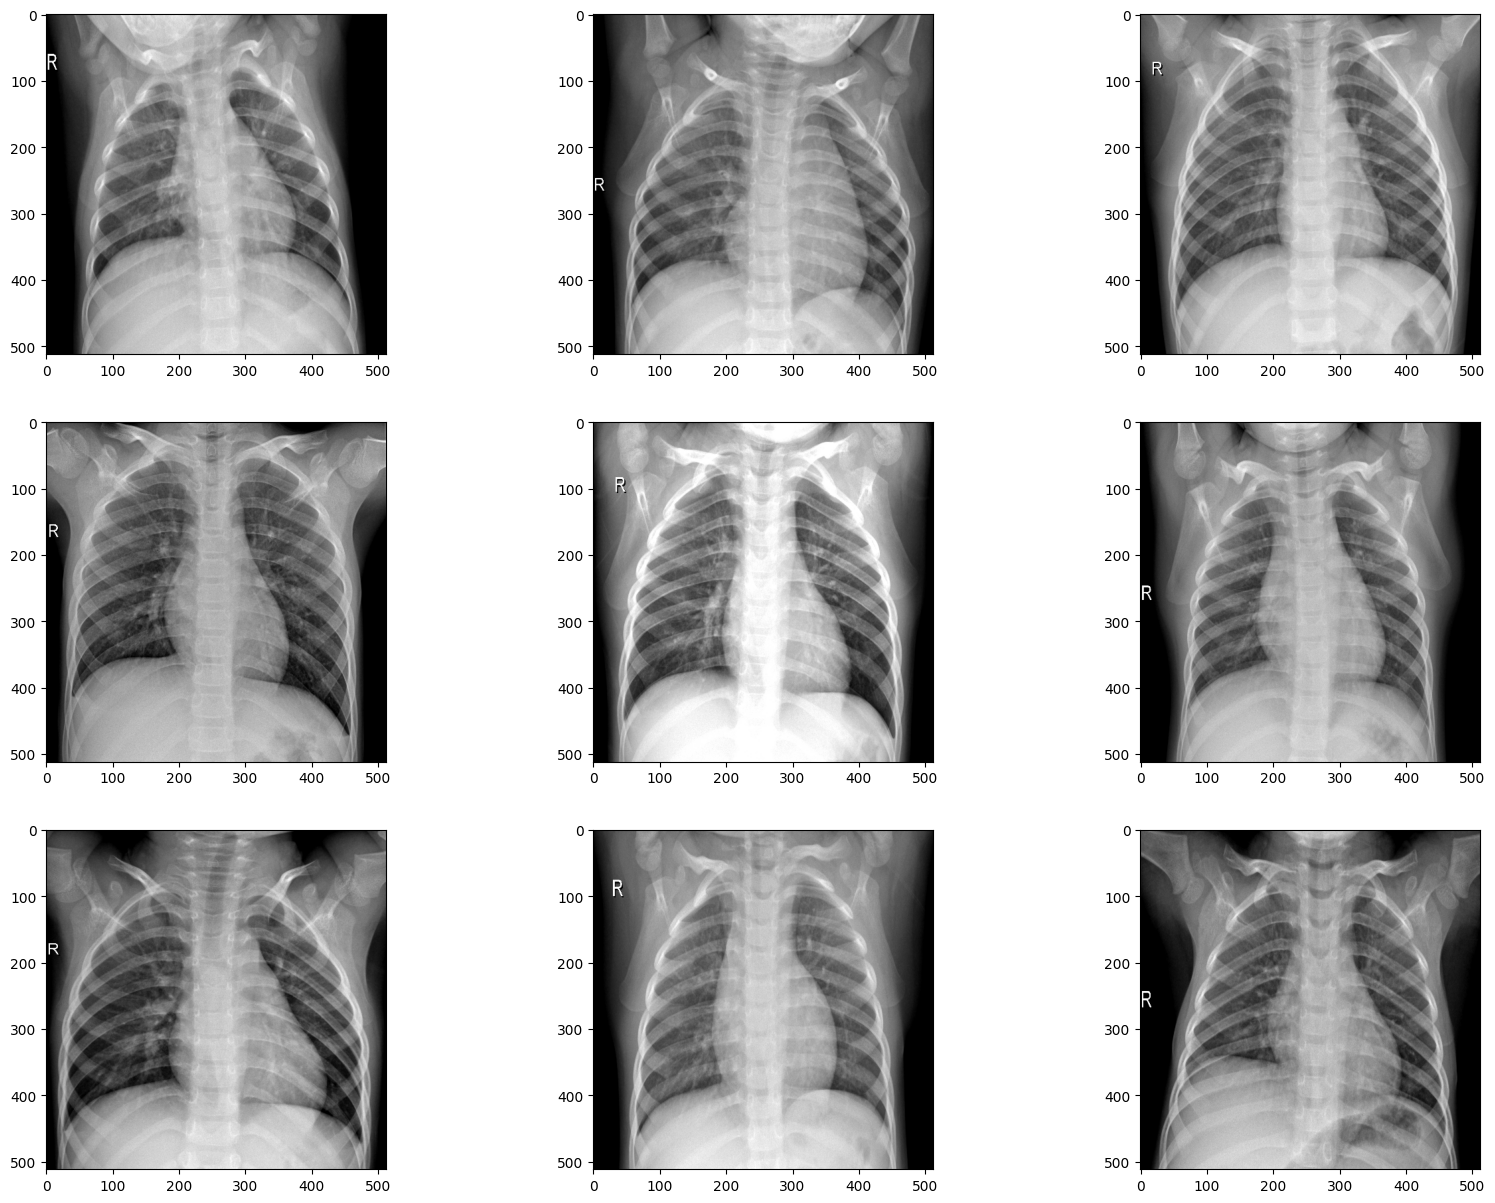

In [270]:
# Showing a grid of 9 random images resized to 512x512 for better view

fig = plt.figure(figsize=(20, 15))
cols, rows = 3, 3
for i in range(1, 10):
    img = cv2.imread(normal_images[i])
    img = cv2.resize(img, (512, 512))
    fig.add_subplot(rows, cols, i)
    plt.imshow(img)


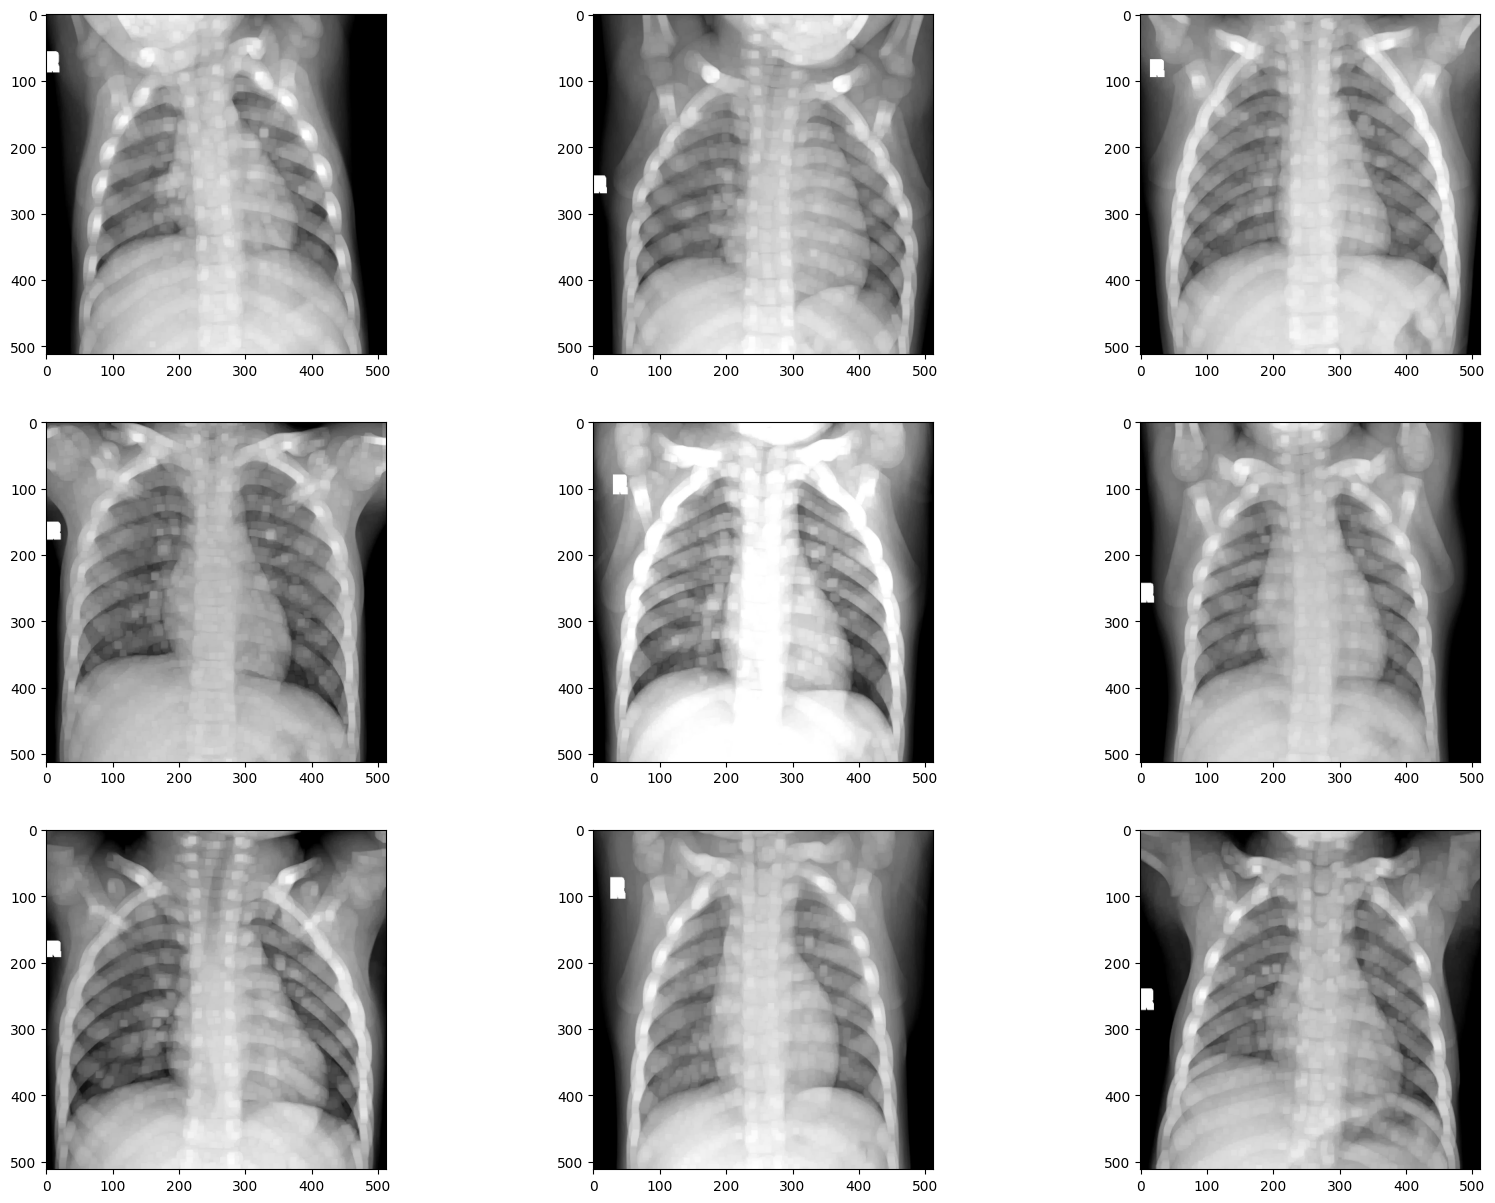

In [271]:
# Showing 9 images after applying dilation effect to highlight features

fig = plt.figure(figsize=(20, 15))
cols, rows = 3, 3

for i in range(1, 10):
    img = cv2.imread(normal_images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    dilated_img = cv2.dilate(img, kernel, iterations=2)
    fig.add_subplot(rows, cols, i)
    plt.imshow(dilated_img)


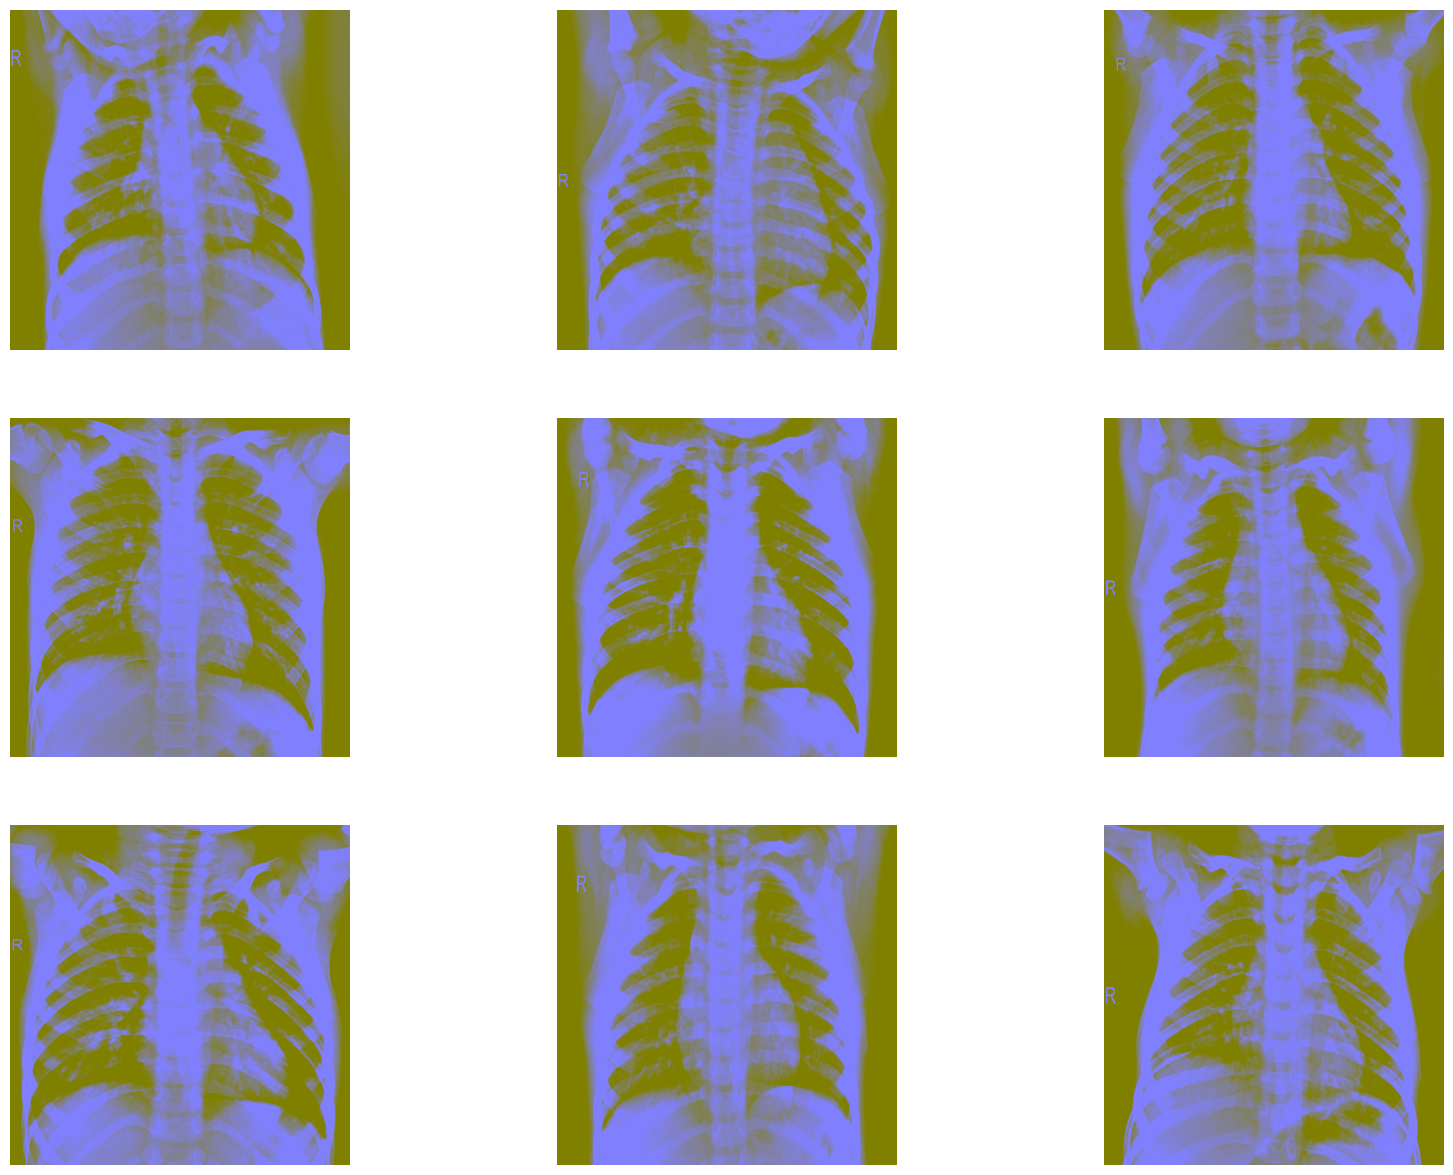

In [272]:
# Showing 9 images after applying sharpening effect using addWeighted method

fig = plt.figure(figsize=(20, 15))
cols, rows = 3, 3

for i in range(1, 10):
    img = cv2.imread(normal_images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), 512/10), -4, 128)
    fig.add_subplot(rows, cols, i)
    plt.imshow(img)
    plt.axis(False)


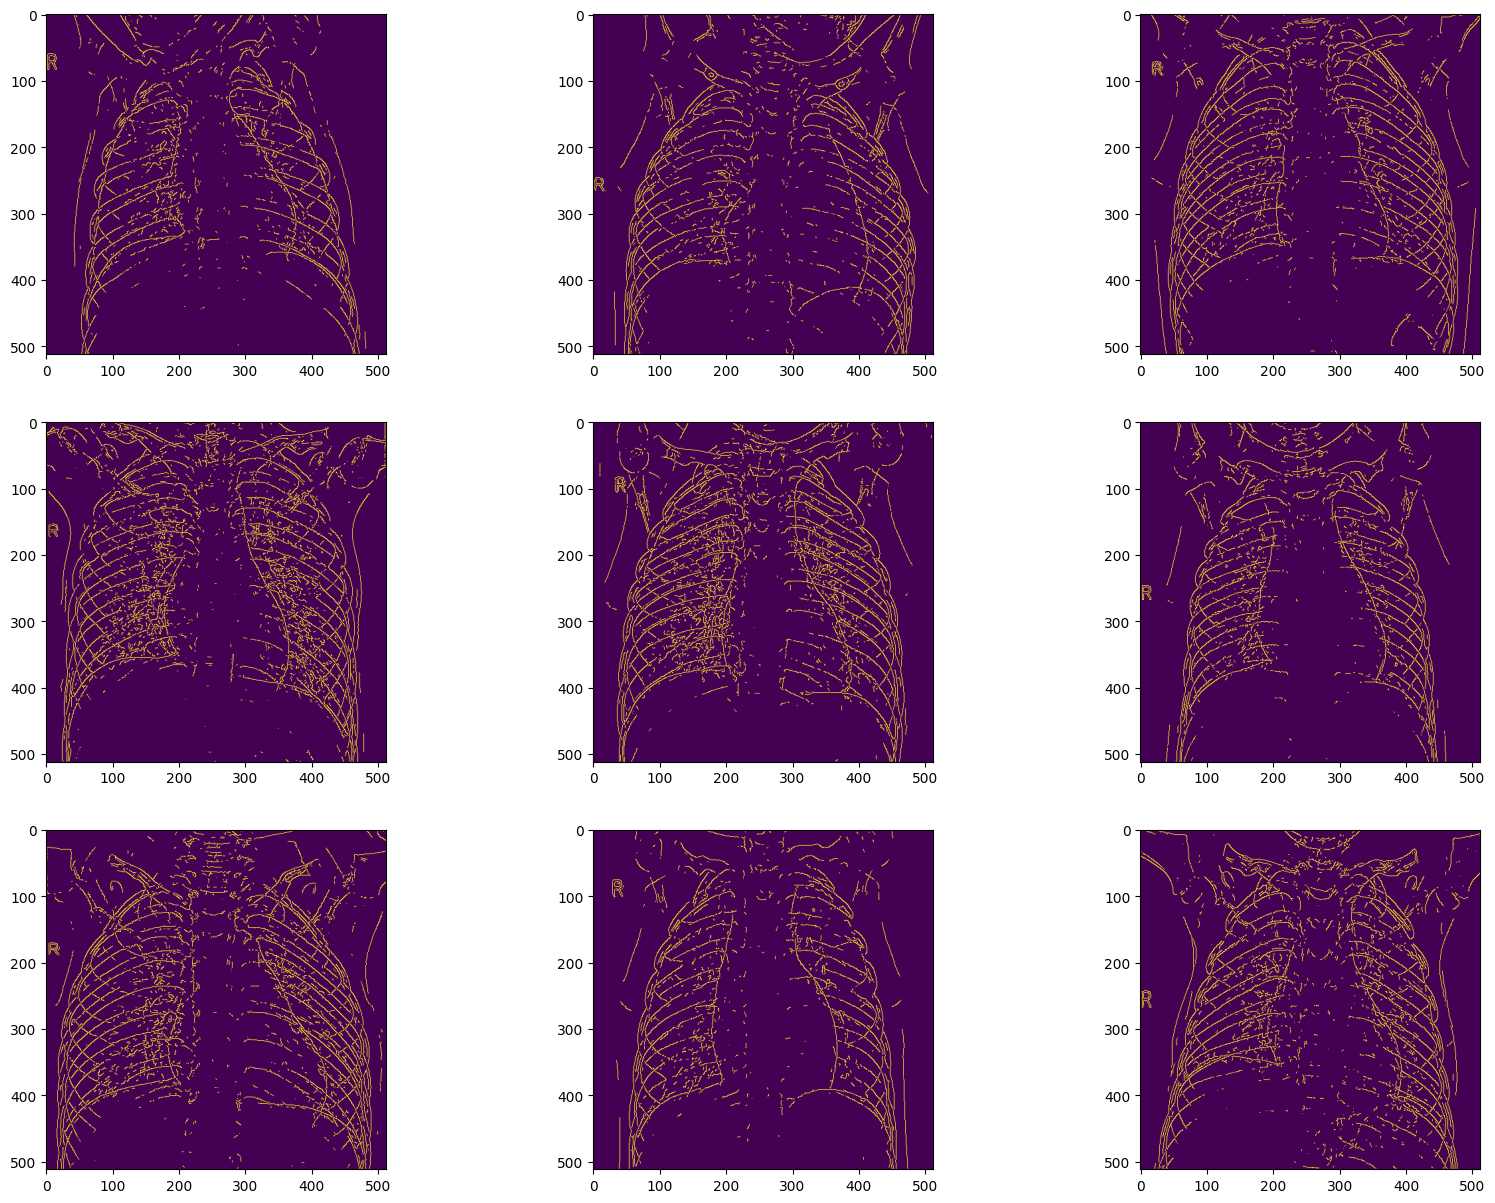

In [273]:
# Showing 9 images after applying edge detection using Canny algorithm

fig = plt.figure(figsize=(20, 15))
cols, rows = 3, 3

for i in range(1, 10):
    img = cv2.imread(normal_images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    detected_edges = cv2.Canny(img, 80, 100)
    fig.add_subplot(rows, cols, i)
    plt.imshow(detected_edges)


In [274]:
# Setting the paths for training, testing and validation folders

train_folder = "/content/chest_xray/chest_xray/train"
test_folder = "/content/chest_xray/chest_xray/test"
val_folder = "/content/chest_xray/chest_xray/val"


In [275]:
# Preparing image data generators for training, validation and testing with augmentations for training set

train_datagen = ImageDataGenerator(
    rescale=1/255.,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=0.3,
    zca_whitening=True,
    width_shift_range=0.25,
    height_shift_range=0.25,
    channel_shift_range=0.35,
    shear_range=0.2,
    zoom_range=0.4
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_folder, class_mode="binary", batch_size=16, target_size=(224, 224))

val_data = val_test_datagen.flow_from_directory(
    val_folder, class_mode="binary", batch_size=16, target_size=(224, 224))

test_data = val_test_datagen.flow_from_directory(
    test_folder, class_mode="binary", batch_size=16, target_size=(224, 224))


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [276]:
# Building a CNN model for binary classification of chest X-ray images

cnn_model = Sequential()

cnn_model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="same", input_shape=(224, 224, 3)))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Conv2D(64, (3, 3), strides=(1, 1), padding="same", activation="relu"))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.2))
cnn_model.add(Conv2D(128, (3, 3), strides=(1, 1), padding="same", activation="relu"))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Conv2D(256, (3, 3), strides=(1, 1), padding="same", activation="relu"))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.2))
cnn_model.add(Flatten())

cnn_model.add(Dense(128, activation="relu"))
cnn_model.add(Dense(64, activation="relu"))
cnn_model.add(Dense(32, activation="relu"))
cnn_model.add(Dense(1, activation="sigmoid"))

cnn_model.summary()


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,821,441 (26.02 MB)

 Trainable params: 6,821,441 (26.02 MB)

 Non-trainable params: 0 (0.00 B)

In [277]:
# Compiling the CNN model with optimizer, loss function and evaluation metric

cnn_model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])


In [278]:
# Setting early stopping to prevent overfitting by monitoring model performance

early_stop = tensorflow.keras.callbacks.EarlyStopping(
    patience=15,
    restore_best_weights=True,
    verbose=1
)


In [279]:
# Training the CNN model with training data, validation data and early stopping

history = cnn_model.fit(
    train_data,
    epochs=20,
    validation_data=val_data,
    steps_per_epoch=100,
    callbacks=[early_stop]
)


Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 334ms/step - accuracy: 0.7101 - loss: 0.6888 - val_accuracy: 0.5625 - val_loss: 0.6892
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 33s 334ms/step - accuracy: 0.7276 - loss: 0.4480 - val_accuracy: 0.6250 - val_loss: 0.7214
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 34s 338ms/step - accuracy: 0.8351 - loss: 0.3432 - val_accuracy: 0.6875 - val_loss: 0.6345
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.8112 - loss: 0.3532 - val_accuracy: 0.6250 - val_loss: 1.3943
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 33s 331ms/step - accuracy: 0.8361 - loss: 0.3460 - val_accuracy: 0.6250 - val_loss: 0.7283
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 33s 330ms/step - accuracy: 0.8385 - loss: 0.3743 - val_accuracy: 0.7500 - val_loss: 0.5590
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 33s 328ms/step - accuracy: 0.8510 - loss: 0.3399 - val_accuracy: 0.7500 - val_loss: 0.4807
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.8452 - loss: 0.426

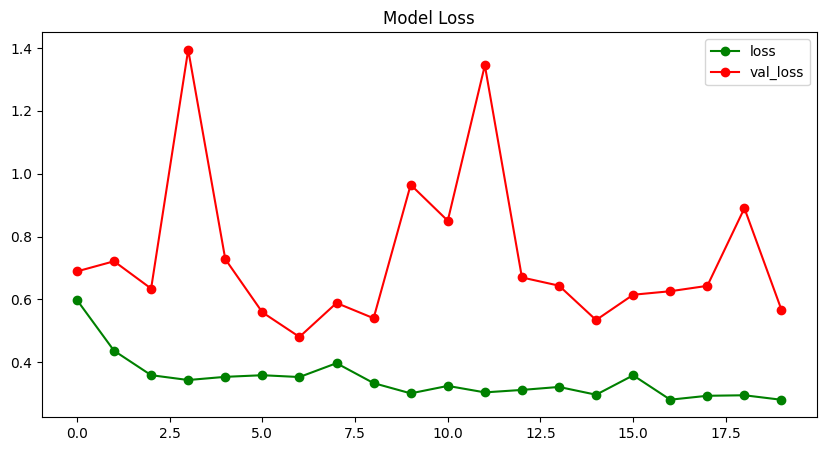

In [280]:
# Plotting training and validation loss to visualize model performance

plt.figure(figsize=(10, 5))
plt.title("Model Loss")
plt.plot(history.history["loss"], "go-")
plt.plot(history.history["val_loss"], "ro-")
plt.legend(["loss", "val_loss"])
plt.show()


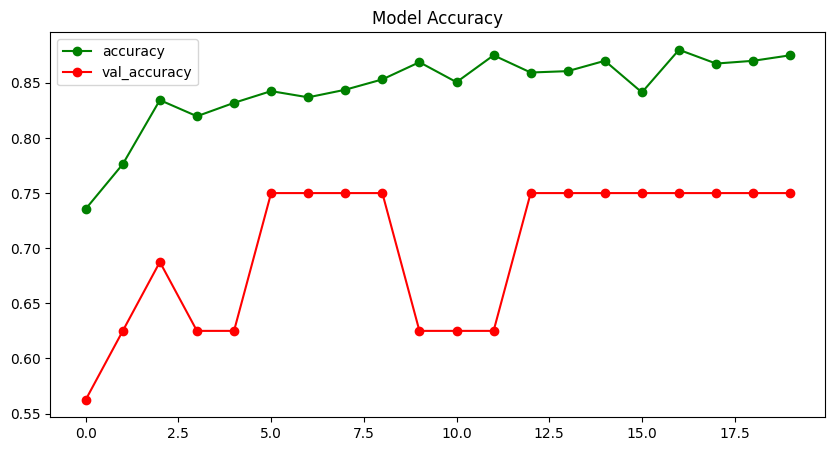

In [281]:
# Plotting training and validation accuracy to visualize how well the model is learning

plt.figure(figsize=(10, 5))
plt.title("Model Accuracy")
plt.plot(history.history["accuracy"], "go-")
plt.plot(history.history["val_accuracy"], "ro-")
plt.legend(["accuracy", "val_accuracy"])
plt.show()


In [282]:
# Evaluating the model on test data and printing the test accuracy and loss

test_loss, test_accuracy = cnn_model.evaluate(test_data, steps=50)
print("The testing accuracy is:", test_accuracy * 100, "%")
print("The testing loss is:", test_loss * 100, "%")


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.7925 - loss: 0.4571 
The testing accuracy is: 80.44871687889099 %
The testing loss is: 42.993906140327454 %


In [283]:
# Loading the VGG16 pre-trained model without top layers for feature extraction

base_model = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling="max",
    classes=2
)

base_model.summary()


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_4          │ (None, 512)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [284]:
# Building a new model using VGG16 as the base for transfer learning

transfer_model = Sequential()
transfer_model.add(base_model)
transfer_model.add(Flatten())

transfer_model.add(Dense(128, activation="relu"))
transfer_model.add(Dense(64, activation="relu"))
transfer_model.add(Dense(32, activation="relu"))
transfer_model.add(Dense(1, activation="sigmoid"))

for layer in base_model.layers:
    layer.trainable = False

transfer_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


In [285]:
# Training the transfer learning model with training data, validation data and early stopping

history = transfer_model.fit(
    train_data,
    epochs=20,
    validation_data=val_data,
    steps_per_epoch=100,
    callbacks=[early_stop]
)


Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 406ms/step - accuracy: 0.8091 - loss: 0.4321 - val_accuracy: 0.7500 - val_loss: 0.5813
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 400ms/step - accuracy: 0.8558 - loss: 0.3216 - val_accuracy: 0.7500 - val_loss: 0.5773
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 402ms/step - accuracy: 0.8565 - loss: 0.2951 - val_accuracy: 0.6875 - val_loss: 0.4826
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - accuracy: 0.8706 - loss: 0.3143 - val_accuracy: 0.6875 - val_loss: 0.4494
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 400ms/step - accuracy: 0.8706 - loss: 0.2955 - val_accuracy: 0.7500 - val_loss: 0.8476
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 398ms/step - accuracy: 0.8811 - loss: 0.2729 - val_accuracy: 0.6875 - val_loss: 1.1279
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 404ms/step - accuracy: 0.8656 - loss: 0.2720 - val_accuracy: 0.6875 - val_loss: 0.4066
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.9263 - loss: 0

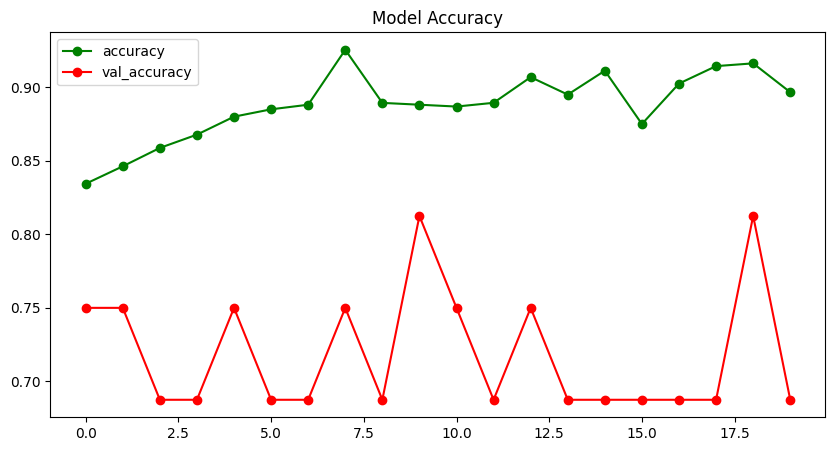

In [287]:
# Plotting training and validation accuracy for the transfer learning model

plt.figure(figsize=(10, 5))
plt.title("Model Accuracy")
plt.plot(history.history["accuracy"], "go-")
plt.plot(history.history["val_accuracy"], "ro-")
plt.legend(["accuracy", "val_accuracy"])
plt.show()


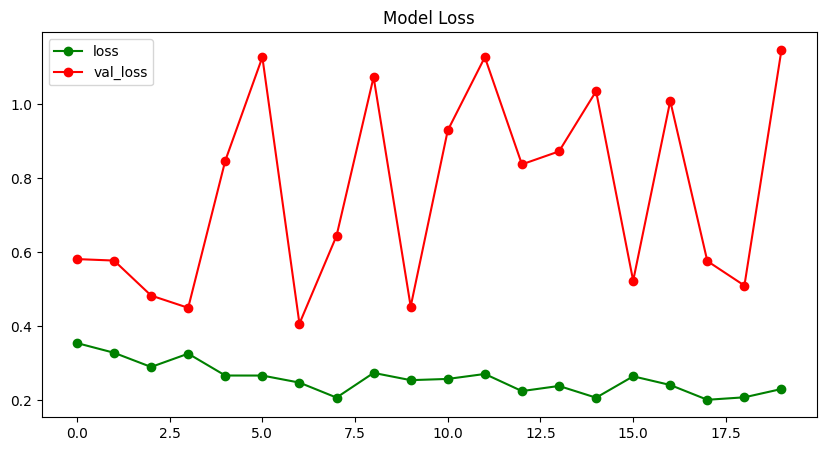

In [288]:
# Plotting training and validation loss for the transfer learning model

plt.figure(figsize=(10, 5))
plt.title("Model Loss")
plt.plot(history.history["loss"], "go-")
plt.plot(history.history["val_loss"], "ro-")
plt.legend(["loss", "val_loss"])
plt.show()


In [289]:
# Evaluating the transfer learning model on test data and printing the test accuracy and loss

test_loss, test_accuracy = transfer_model.evaluate(test_data, steps=50)
print("The testing accuracy is:", test_accuracy * 100, "%")
print("The testing loss is:", test_loss * 100, "%")


50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 223ms/step - accuracy: 0.7752 - loss: 0.4504
The testing accuracy is: 78.20512652397156 %
The testing loss is: 42.94950067996979 %


In [290]:
# Loading the ResNet50V2 pre-trained model without top layers for feature extraction

resnet_base = tensorflow.keras.applications.ResNet50V2(
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling="max",
    include_top=False,
    classes=2
)

for layer in resnet_base.layers:
    layer.trainable = False


In [291]:
# Building a new model using ResNet50V2 as the base for transfer learning

resnet_model = Sequential()
resnet_model.add(resnet_base)
resnet_model.add(Flatten())

resnet_model.add(Dense(128, activation="relu"))
resnet_model.add(Dense(64, activation="relu"))
resnet_model.add(Dense(32, activation="relu"))
resnet_model.add(Dense(1, activation="sigmoid"))

for layer in resnet_base.layers:
    layer.trainable = False

resnet_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


In [292]:
# Training the ResNet50V2-based model with training data, validation data and early stopping

history = resnet_model.fit(
    train_data,
    epochs=20,
    validation_data=val_data,
    steps_per_epoch=100,
    callbacks=[early_stop]
)


Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 45s 389ms/step - accuracy: 0.8044 - loss: 0.5009 - val_accuracy: 0.6875 - val_loss: 0.4392
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 369ms/step - accuracy: 0.8932 - loss: 0.2572 - val_accuracy: 0.8125 - val_loss: 0.6146
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 373ms/step - accuracy: 0.8913 - loss: 0.2595 - val_accuracy: 0.8750 - val_loss: 0.3401
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.8793 - loss: 0.2965 - val_accuracy: 0.8750 - val_loss: 0.4345
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9215 - loss: 0.2041 - val_accuracy: 0.8125 - val_loss: 0.3484
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 366ms/step - accuracy: 0.9199 - loss: 0.2037 - val_accuracy: 0.8750 - val_loss: 0.3053
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 364ms/step - accuracy: 0.9134 - loss: 0.2258 - val_accuracy: 0.8750 - val_loss: 0.3017
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.9339 - loss: 0.15

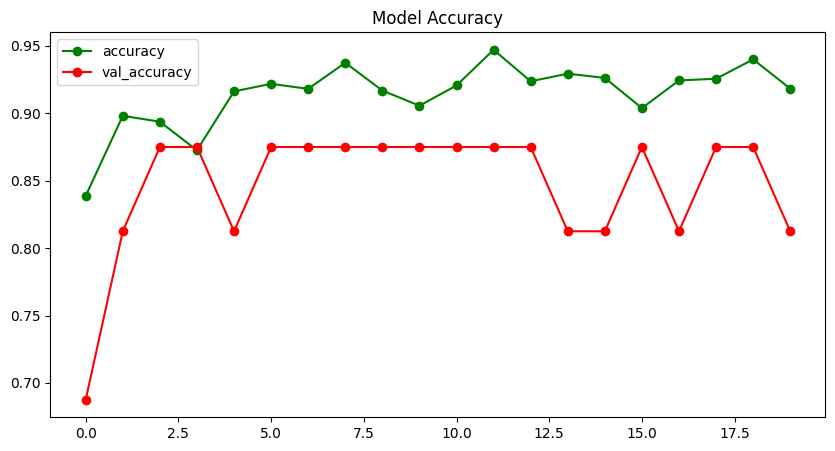

In [293]:
# Plotting training and validation accuracy for the ResNet50V2 model

plt.figure(figsize=(10, 5))
plt.title("Model Accuracy")
plt.plot(history.history["accuracy"], "go-")
plt.plot(history.history["val_accuracy"], "ro-")
plt.legend(["accuracy", "val_accuracy"])
plt.show()


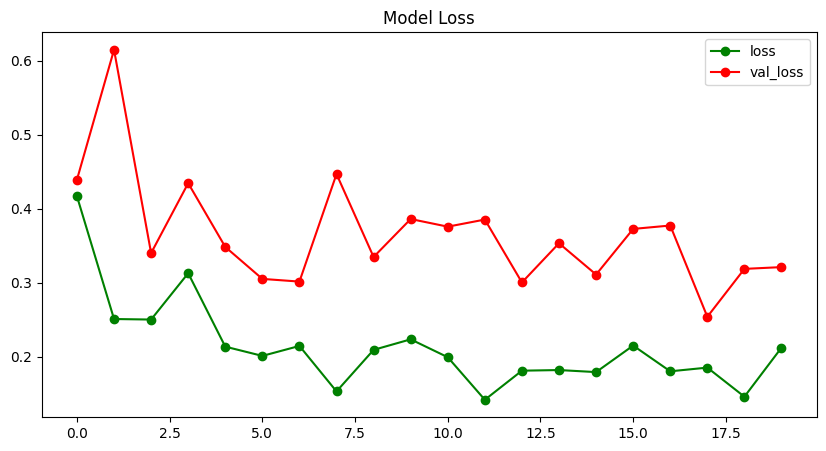

In [294]:
# Plotting training and validation loss for the ResNet50V2 model

plt.figure(figsize=(10, 5))
plt.title("Model Loss")
plt.plot(history.history["loss"], "go-")
plt.plot(history.history["val_loss"], "ro-")
plt.legend(["loss", "val_loss"])
plt.show()


In [295]:
# Evaluating the ResNet50V2 model on test data and printing the test accuracy and loss

test_loss, test_accuracy = resnet_model.evaluate(test_data, steps=50)
print("The testing accuracy is:", test_accuracy * 100, "%")
print("The testing loss is:", test_loss * 100, "%")


50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - accuracy: 0.8997 - loss: 0.2478
The testing accuracy is: 90.86538553237915 %
The testing loss is: 24.18680638074875 %


In [296]:
# Making a prediction on a new chest X-ray image using the ResNet50V2 model

new_image_path = "/content/chest_xray/chest_xray/test/PNEUMONIA/person100_bacteria_478.jpeg"
test_image = image.load_img(new_image_path, target_size=(224, 224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image = test_image / 255

result = resnet_model.predict(test_image)

train_data.class_indices

if result[0][0] == 0:
    prediction = "N O R M A L"
else:
    prediction = "P N E U M O N I A"

print(prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
P N E U M O N I A


In [297]:
# Saving the trained ResNet50V2 model to disk

resnet_model.save("my_pneumonia_detection_model.keras")
print(colored("Model was successfully saved to disk...", color="green", attrs=["bold", "dark"]))


Model was successfully saved to disk...


In [298]:
# Loading the saved model from disk and displaying its summary

model_loaded = tensorflow.keras.models.load_model("/content/my_pneumonia_detection_model.keras")
model_loaded.summary()


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,382,725 (93.01 MB)

 Trainable params: 272,641 (1.04 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

 Optimizer params: 545,284 (2.08 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
This image is 64.889 percent N O R M A L


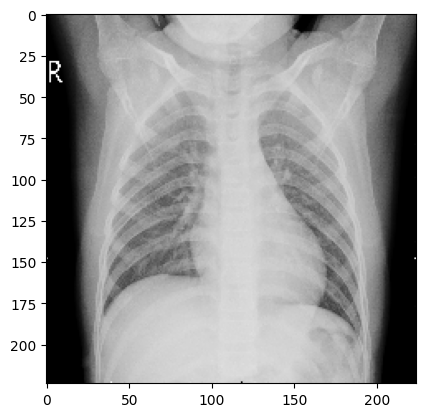

In [299]:
# Defining a function to predict if a chest X-ray image is normal or pneumonia using the saved model

def image_prediction(new_image_path):
    test_image = image.load_img(new_image_path, target_size=(224, 224))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    test_image = test_image / 255.0

    model_loaded = tensorflow.keras.models.load_model("/content/my_pneumonia_detection_model.keras")
    prediction = model_loaded.predict(test_image)

    test_image_for_plotting = image.load_img(new_image_path, target_size=(224, 224))
    plt.imshow(test_image_for_plotting)

    if prediction[0] > 0.5:
        statistic = prediction[0] * 100
        print("This image is %.3f percent %s" % (statistic, "P N E U M O N I A"))
    else:
        statistic = (1.0 - prediction[0]) * 100
        print("This image is %.3f percent %s" % (statistic, "N O R M A L"))

# Calling the function to make a prediction on a new image
image_prediction("/content/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg")


In [300]:
# Setting the test directory path and creating empty lists for test data and labels

test_folder_path = "/content/chest_xray/test"
test_data = []
test_labels = []


In [301]:
# Loading and preprocessing test images manually, and creating corresponding labels

for category in ["/NORMAL/", "/PNEUMONIA/"]:
    for img_name in os.listdir(test_folder_path + category):
        img = plt.imread(test_folder_path + category + img_name)
        img = cv2.resize(img, (224, 224))
        img = np.dstack([img, img, img])
        img = img.astype("float32") / 255

        if category == "/NORMAL/":
            label = 0
        else:
            label = 1

        test_data.append(img)
        test_labels.append(label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)


20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 506ms/step


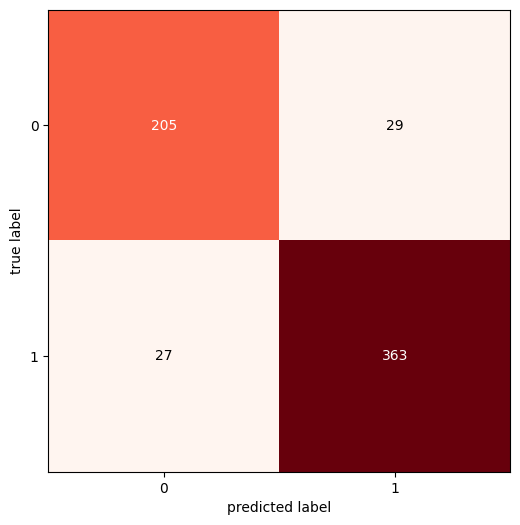

In [302]:
# Predicting on the test data and plotting the confusion matrix to evaluate performance

predictions = model_loaded.predict(test_data)
conf_m = confusion_matrix(test_labels, np.round(predictions))
acc = accuracy_score(test_labels, np.round(predictions)) * 100
tn, fp, fn, tp = conf_m.ravel()

fig, ax = plot_confusion_matrix(conf_mat=conf_m, figsize=(6, 6), cmap=matplotlib.pyplot.cm.Reds)
plt.show()


In [303]:
# Calculating and printing accuracy, precision, recall, and F1-score for the model

precision = tp / (tp + fp) * 100
recall = tp / (tp + fn) * 100
print("Accuracy: {}%".format(acc))
print("Precision: {}%".format(precision))
print("Recall: {}%".format(recall))
print("F1-score: {}".format(2 * precision * recall / (precision + recall)))


Accuracy: 91.02564102564102%
Precision: 92.60204081632652%
Recall: 93.07692307692308%
F1-score: 92.8388746803069


In [304]:
# Converting model predictions to binary classes (0 or 1) based on a threshold of 0.5

predictions = []
preds = model_loaded.predict(test_data)
for pred in preds:
    if pred >= 0.5:
        predictions.append(1)
    else:
        predictions.append(0)

predictions[:15]


20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 415ms/step


[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [305]:
# Finding indices of correct and incorrect predictions by comparing with true labels

correct_predictions = np.nonzero(predictions == test_labels)[0]
incorrect_predictions = np.nonzero(predictions != test_labels)[0]

print("Indices of correct predictions:\n", correct_predictions[:15])
print("\nIndices of incorrect predictions:\n", incorrect_predictions[:15])


Indices of correct predictions:
 [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15]

Indices of incorrect predictions:
 [  5  18  26  38  40  47  51  65  75  80 102 111 119 122 133]


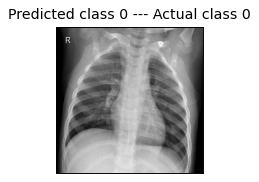

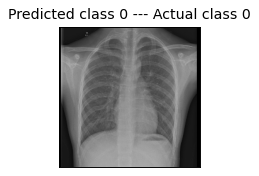

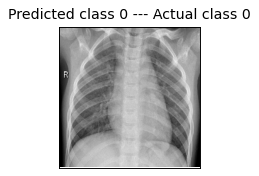

In [306]:
# Displaying a few correctly predicted images along with their predicted and actual labels

i = 0
for idx in correct_predictions[:3]:
    plt.figure(figsize=(8, 6), dpi=85)
    plt.subplot(3, 1, i + 1)
    plt.xticks([]), plt.yticks([])
    plt.imshow(test_data[idx].reshape(224, 224, 3))
    plt.title("Predicted class {} --- Actual class {}".format(predictions[idx], test_labels[idx]))
    plt.tight_layout()
    i += 1


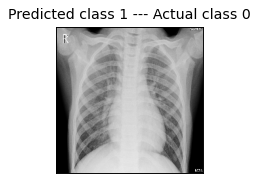

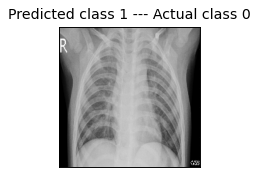

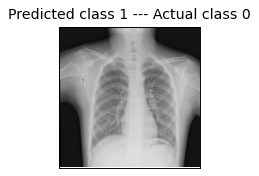

In [307]:
# Displaying a few incorrectly predicted images along with their predicted and actual labels

i = 0
for idx in incorrect_predictions[:3]:
    plt.figure(figsize=(8, 6), dpi=85)
    plt.subplot(3, 1, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_data[idx].reshape(224, 224, 3))
    plt.title("Predicted class {} --- Actual class {}".format(predictions[idx], test_labels[idx]))
    plt.tight_layout()
    i += 1
